# Data loading and Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
#print(os.listdir("../input"))

In [3]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

#from fastai.imports import *
#from fastai.structured import *

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
import scipy.signal as sg
warnings.filterwarnings("ignore")

from scipy import stats

In [5]:
import gc
from itertools import product
import random
import pickle

In [6]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [7]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: #and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
def merge_dataset(df):
    
    df = pd.merge(df, shops, on=['shop_id'], how='left')
    df = pd.merge(df, item, on=['item_id'], how='left')
    df = pd.merge(df, item_cat, on=['item_category_id'], how='left')
    df['city_code'] = df['city_code'].astype(np.int8)
    df['item_category_id'] = df['item_category_id'].astype(np.int8)
    df['type_code'] = df['type_code'].astype(np.int8)
    df['subtype_code'] = df['subtype_code'].astype(np.int8)
        
    return df

In [9]:
def target_generate(df):
    df = pd.merge(df, sales_group[['date_block_num','shop_id','item_id','revenue_month','item_cnt_month']], on=cols, how='left')
    df['item_cnt_month'] = (df['item_cnt_month']
                                    .fillna(0)
                                    .clip(0,20) # NB clip target here
                                    .astype(np.float16))
    
    df['revenue_month'] = (df['revenue_month']
                                    .fillna(0)
                                    .clip(0,20) # NB clip target here
                                    .astype(np.float16))
    return df

In [10]:
lags = np.arange(12) + 1
def lag_feature(df, lags, col = 'item_cnt_month', fillna = '0'):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        
        if fillna == 'median':
            df[f'{col}_lag_{i}'].fillna(df[f'{col}_lag_{i}'].median(), inplace = True)
        elif fillna == 'mean':
            df[f'{col}_lag_{i}'].fillna(df[f'{col}_lag_{i}'].mean(), inplace = True)
        elif fillna == '0':
            df.fillna(0, inplace = True)
        del shifted
        gc.collect()    
        
    del tmp
    
    return df

In [11]:
sales_train = pd.read_csv('./input/sales_train_v2.csv')
test = pd.read_csv('./input/test.csv')

In [12]:
item_cat = pd.read_csv('./input/item_categories.csv')
item = pd.read_csv('./input/items.csv')
shops = pd.read_csv('./input/shops.csv')

In [13]:
def remove_duplicate():
    # Якутск Орджоникидзе, 56
    sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
    test.loc[test.shop_id == 0, 'shop_id'] = 57
    # Якутск ТЦ "Центральный"
    sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
    test.loc[test.shop_id == 1, 'shop_id'] = 58
    # Жуковский ул. Чкалова 39м²
    sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
    test.loc[test.shop_id == 10, 'shop_id'] = 11
    #
    sales_train.loc[sales_train.shop_id == 39, 'shop_id'] = 40
    test.loc[test.shop_id == 39, 'shop_id'] = 40
    
remove_duplicate()

In [14]:
def preprocess_sales_train(df):
    df = df[df['item_cnt_day'] < 1000]
    df = df[df['item_price'] < 100000]
    return df

In [15]:
sales_train = preprocess_sales_train(sales_train)
median = sales_train[(sales_train.shop_id==32)&(sales_train.item_id==2973)&(sales_train.date_block_num==4)&(sales_train.item_price>0)].item_price.median()
sales_train.loc[sales_train.item_price<0, 'item_price'] = median

In [16]:
#def subcategory_generation():
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
#shops.head()

#shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
#shops = shops[['shop_id','city_code']]

In [17]:
shops['shop_type'].unique()

array(['NO_DATA', 'тц', 'трк', 'трц', 'мтрц', 'тк'], dtype=object)

In [18]:
item['name_1'], item['name_2'] = item['item_name'].str.split('[', 1).str
item['name_1'], item['name_3'] = item['item_name'].str.split('(', 1).str

item['name_2'] = item['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
item['name_3'] = item['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
item = item.fillna('0')

In [19]:
item_cat['split'] = item_cat['item_category_name'].str.split('-')
item_cat['type'] = item_cat['split'].map(lambda x: x[0].strip())
item_cat['type_code'] = LabelEncoder().fit_transform(item_cat['type'])
# if subtype is nan then type
item_cat['subtype'] = item_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cat['subtype_code'] = LabelEncoder().fit_transform(item_cat['subtype'])
item_cat = item_cat[['item_category_id','type_code', 'subtype_code']]
#subcategory_generation()

In [20]:
l_cat = list(item_cat.item_category_id)

In [21]:
for ind in range(0,1):

     l_cat[ind] = 'PC Headsets / Headphones'

for ind in range(1,8):

     l_cat[ind] = 'Access'

l_cat[8] = 'Tickets (figure)'

l_cat[9] = 'Delivery of goods'

for ind in range(10,18):

    l_cat[ind] = 'Consoles'

for ind in range(18,25):

    l_cat[ind] = 'Consoles Games'

l_cat[25] = 'Accessories for games'

for ind in range(26,28):

    l_cat[ind] = 'phone games'

for ind in range(28,32):

    l_cat[ind] = 'CD games'

for ind in range(32,37):

    l_cat[ind] = 'Card'

for ind in range(37,43):

    l_cat[ind] = 'Movie'

for ind in range(43,55):

    l_cat[ind] = 'Books'

for ind in range(55,61):

    l_cat[ind] = 'Music'

for ind in range(61,73):

    l_cat[ind] = 'Gifts'

for ind in range(73,79):

    l_cat[ind] = 'Soft'

for ind in range(79,81):

    l_cat[ind] = 'Office'

for ind in range(81,83):

    l_cat[ind] = 'Clean'

l_cat[83] = 'Elements of a food'

In [22]:
from sklearn import preprocessing

lb = preprocessing.LabelEncoder()
item_cat['item_cat_id_fix'] = lb.fit_transform(l_cat)

In [23]:
item_cat.head()

,item_category_id,type_code,subtype_code,item_cat_id_fix
0,0,0,29,14
1,1,1,9,0
2,2,1,10,0
3,3,1,11,0
4,4,1,13,0


In [24]:
# label encoding shop
shops['city_code'] = LabelEncoder().fit_transform(shops['shop_city'])
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['shop_type'])

In [25]:
shops.head()

,shop_name,shop_id,shop_city,shop_type,city_code,shop_type_code
0,якутск орджоникидзе фран,0,якутск,NO_DATA,29,0
1,якутск тц центральный фран,1,якутск,тц,29,5
2,адыгея тц мега,2,адыгея,тц,0,5
3,балашиха трк октябрькиномир,3,балашиха,трк,1,3
4,волжский тц волга молл,4,волжский,тц,2,5


In [26]:
# label encoding item
item['name_1_code'] = LabelEncoder().fit_transform(item['name_1'])
item['name_2_code'] = LabelEncoder().fit_transform(item['name_2'])
item['name_3_code'] = LabelEncoder().fit_transform(item['name_3'])

In [27]:
len(item['name_1'].unique()), len(item['name_1_code'].unique())

(20611, 20611)

In [28]:
item.head()

,item_name,item_id,item_category_id,name_1,name_2,name_3,name_1_code,name_2_code,name_3_code
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d,0,4,1331
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0,1,64,42
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d,2,4,1011
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d,3,4,1010
4,***КОРОБКА (СТЕКЛО) D,4,40,***КОРОБКА,0,стекло d,4,4,1572


In [29]:
item.drop(['item_name'], axis=1, inplace=True)

In [30]:
sales_train['revenue'] = sales_train['item_price'] *  sales_train['item_cnt_day']

In [31]:
gc.collect()

34

In [32]:
sales_train = reduce_mem_usage(sales_train)

Mem. usage decreased to 89.59 Mb (50.0% reduction)


# Categorize test and validation data set

In [33]:
cols = ['date_block_num','shop_id','item_id']

In [34]:
test['date_block_num']= 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test = test[cols]

In [35]:
sales_group = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
                                    'item_cnt_day': ['sum'],
                                    'revenue': ['sum']
})

In [36]:
sales_group.columns = ['_'.join(col).strip() for col in sales_group.columns.values]
sales_group.rename(columns = {
                            'revenue_sum': 'revenue_month',
                            'item_cnt_day_sum': 'item_cnt_month',
                            },
                 inplace = True) 
sales_group.reset_index(inplace=True)

In [37]:
# Initialize category column, 4 means haven't assigned any tag
test['category'] = 4

In [38]:
shop_train = sales_group.loc[sales_group['date_block_num']<=33]['shop_id'].unique()
item_lst = sales_group.loc[sales_group['date_block_num']<=33]['item_id'].unique()
shop_test = test.loc[test['category']==0]['shop_id'].unique()

In [39]:
sales_group['date_block_num'].max()

33

Normal items with shop/item in sale history

In [40]:
for shop in shop_train:
    item_lst_shop = sales_group.loc[(sales_group['date_block_num']<=33)&(sales_group['shop_id'] == shop)]['item_id'].unique()
    test.loc[(test['shop_id'] == shop) & (test['item_id'].isin(item_lst_shop)), 'category'] = 0

Items w/o sale history

In [41]:
test.loc[~(test['item_id'].isin(item_lst)), 'category'] = 2

Items w sale history but no good shop/item pair

In [42]:
test.loc[test['category'] == 4, 'category'] = 1

In [43]:
len(test.loc[test['category']==0]), len(test.loc[test['category']==1]), len(test.loc[test['category']==2])

(111511, 87443, 15246)

# df_price

In [52]:
df_price = []
for i in range(34):
    #sales = sales_train[sales_train.date_block_num==i]
    df_price.append(np.array(list(product([i], sales_train.shop_id.unique(), sales_train.item_id.unique())), dtype='int16'))
    
df_price = pd.DataFrame(np.vstack(df_price), columns=cols)
df_price['date_block_num'] = df_price['date_block_num'].astype(np.int8)
df_price['shop_id'] = df_price['shop_id'].astype(np.int8)
df_price['item_id'] = df_price['item_id'].astype(np.int16)
df_price.sort_values(cols,inplace=True)
gc.collect()

21

In [53]:
group = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_price': [#'max','min',
                                                                                          'mean',
                                                                                          #'median'
                                                                                            ]})
group.columns = ['mean_price']
group.reset_index(inplace = True)

In [54]:
df_price = pd.merge(df_price, group, how = 'left', on = ['date_block_num','shop_id','item_id'])

In [55]:
df_price['missing'] = 0
df_price.loc[df_price['mean_price'].isnull(),'missing'] = 1

In [58]:
df_price['mean_price'] = df_price.groupby(['date_block_num','item_id'])['mean_price'].transform(lambda x: x.fillna(x.mean()))

In [66]:
df_price['mean_price'] = df_price.groupby(['shop_id','item_id'])['mean_price'].fillna(method='ffill')

In [74]:
df_price['mean_price'] = df_price.groupby(['shop_id','item_id'])['mean_price'].fillna(method='bfill')

In [76]:
del group
gc.collect()

14

In [86]:
df_price['missing'] = df_price['missing'].astype(np.int8)

In [93]:
gc.collect()

0

In [94]:
def neighbor_feature(df, nearst, col = 'item_cnt_month', fillna = '0'):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    
    nearst_lst = np.arange(-nearst, nearst+1)
    nearst_lst = list(set(nearst_lst).difference(set([0])))
    for i in nearst_lst:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_nearst_'+str(i)]
        shifted['item_id'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        
        if fillna == 'median':
            df[f'{col}_nearst_{i}'].fillna(df[f'{col}_nearst_{i}'].median(), inplace = True)
        elif fillna == 'mean':
            df[f'{col}_nearst_{i}'].fillna(df[f'{col}_nearst_{i}'].mean(), inplace = True)
        elif fillna == '0':
            df.fillna(0, inplace = True)
            
        del shifted
        gc.collect()
            
        
    del tmp
    gc.collect()
    return df

In [95]:
t = time.time()

nearst = 30
df_price = neighbor_feature(df_price, nearst, 'mean_price', 'no')

time.time() - t

5558.741565465927

In [74]:
#for col in nearst_feature_lst:
#    df_price[col] = df_price[col].astype('float16')
#    gc.collect()

In [96]:
for num_nearst in [2, 
                   10, 20, 30
                  ]:
    nearst_lst = np.arange(-num_nearst, num_nearst+1)
    nearst_lst = list(set(nearst_lst).difference(set([0])))
    nearst_feature_lst = [f'mean_price_nearst_{element}' for element in nearst_lst]

    df_price[f'mean_price_avg_nearst_{num_nearst}'] = df_price[nearst_feature_lst].mean(axis = 1)
    
df_price.drop(nearst_feature_lst, axis = 1, inplace = True)

In [98]:
df_price.columns.to_series()[np.isinf(df_price).any()]

Series([], dtype: object)

In [100]:
df_price.columns[df_price.isna().any()].tolist()

[]

In [97]:
df_price.head()

,date_block_num,shop_id,item_id,mean_price,missing,mean_price_avg_nearst_2,mean_price_avg_nearst_10,mean_price_avg_nearst_20,mean_price_avg_nearst_30
0,0,2,0,58.0,1,2274.0,500.600006103515625,284.850006103515625,393.413208007812500
1,0,2,1,4490.0,1,72.0,57.454544067382812,63.000000000000000,260.303100585937500
2,0,2,2,58.0,1,1176.5,437.750000000000000,262.863647460937500,401.138702392578125
3,0,2,3,100.0,1,1158.5,405.307678222656250,250.826080322265625,402.831481933593750
4,0,2,4,58.0,1,71.5,381.357147216796875,246.208328247070312,396.332763671875000


In [101]:
with open('df_price_01.pickle', 'wb') as handle:
    pickle.dump(df_price, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [44]:
with open('df_price_01.pickle', 'rb') as handle:
    df_price = pickle.load(handle)

For category 2

In [112]:
df_price_2 = []
for i in range(34):
    df_price_2.append(np.array(list(product([i], sales_train.shop_id.unique(), test.loc[test['category']==2].item_id.unique())), dtype='int16'))
    
df_price_2 = pd.DataFrame(np.vstack(df_price_2), columns=cols)
df_price_2['date_block_num'] = df_price_2['date_block_num'].astype(np.int8)
df_price_2['shop_id'] = df_price_2['shop_id'].astype(np.int8)
df_price_2['item_id'] = df_price_2['item_id'].astype(np.int16)
df_price_2.sort_values(cols,inplace=True)
gc.collect()

28

In [113]:
gc.collect()

0

In [114]:
len(df_price_2), len(df_price)

(691152, 41518624)

In [115]:
def neighbor_feature_2(df1, df2, nearst, col = 'item_cnt_month', fillna = '0'):
    tmp = df2[['date_block_num', 'shop_id', 'item_id', col]]
    
    nearst_lst = np.arange(-nearst, nearst+1)
    nearst_lst = list(set(nearst_lst).difference(set([0])))
    for i in nearst_lst:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_nearst_'+str(i)]
        shifted['item_id'] += i
        df1 = pd.merge(df1, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        
        if fillna == 'median':
            df1[f'{col}_nearst_{i}'].fillna(df1[f'{col}_nearst_{i}'].median(), inplace = True)
        elif fillna == 'mean':
            df1[f'{col}_nearst_{i}'].fillna(df1[f'{col}_nearst_{i}'].mean(), inplace = True)
        elif fillna == '0':
            df1.fillna(0, inplace = True)
            
        
    del tmp
    gc.collect()
    return df1

In [116]:
t = time.time()

nearst = 30
df_price_2 = neighbor_feature_2(df_price_2, df_price, nearst, 'mean_price', 'no')

time.time() - t

1031.9123268127441

In [107]:
#nearst_lst = np.arange(-nearst, nearst+1)
#nearst_lst = list(set(nearst_lst).difference(set([0])))
#nearst_feature_lst = [f'mean_price_nearst_{element}' for element in nearst_lst]

#for col in nearst_feature_lst:
#    df_price_2[col] = df_price_2[col].astype('float16')
#    gc.collect()

In [117]:
for num_nearst in [1, 2, 10, 20, 30]:
    nearst_lst = np.arange(-num_nearst, num_nearst+1)
    nearst_lst = list(set(nearst_lst).difference(set([0])))
    nearst_feature_lst = [f'mean_price_nearst_{element}' for element in nearst_lst]

    df_price_2[f'mean_price_avg_nearst_{num_nearst}'] = df_price_2[nearst_feature_lst].mean(axis = 1)
    
df_price_2.drop(nearst_feature_lst, axis = 1, inplace = True)

In [118]:
df_price_2.columns.to_series()[np.isinf(df_price_2).any()]

Series([], dtype: object)

In [120]:
df_price_2.columns[df_price_2.isna().any()].tolist()

['mean_price_avg_nearst_1', 'mean_price_avg_nearst_2']

In [131]:
df_price_2.loc[df_price_2['mean_price_avg_nearst_1'].isnull()].head()

,date_block_num,shop_id,item_id,mean_price_avg_nearst_1,mean_price_avg_nearst_2,mean_price_avg_nearst_10,mean_price_avg_nearst_20,mean_price_avg_nearst_30
25,0,2,1253,NaN,849.0,550.75939941406250,582.65826416015625,596.4075927734375
46,0,2,2323,NaN,999.0,1219.23339843750000,998.18762207031250,1096.7763671875000
47,0,2,2324,NaN,NaN,1226.37622070312500,964.72448730468750,1096.3532714843750
48,0,2,2325,NaN,NaN,958.51904296875000,920.59649658203125,1090.7977294921875
49,0,2,2326,NaN,NaN,690.66192626953125,907.22149658203125,1076.2255859375000


In [122]:
df_price_2.head()

,date_block_num,shop_id,item_id,mean_price_avg_nearst_1,mean_price_avg_nearst_2,mean_price_avg_nearst_10,mean_price_avg_nearst_20,mean_price_avg_nearst_30
0,0,2,83,184.0,236.833328247070312,345.907257080078125,1310.123168945312500,1023.165771484375000
1,0,2,140,196.5,235.250000000000000,187.023803710937500,180.845077514648438,176.934509277343750
2,0,2,168,160.5,204.750000000000000,184.210525512695312,178.555374145507812,167.678039550781250
3,0,2,173,165.0,185.250000000000000,180.578948974609375,165.918624877929688,163.691970825195312
4,0,2,204,164.5,174.500000000000000,167.066665649414062,155.233322143554688,160.680557250976562


In [123]:
with open('df_price_2.pickle', 'wb') as handle:
    pickle.dump(df_price_2, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
#with open('df_prediction_20191031.pickle', 'rb') as handle:
#    test = pickle.load(handle)

In [158]:
del df_price, df_price_2
gc.collect()

2927171

# EDA

In [125]:
group = df_price.groupby(['date_block_num','item_id']).agg({'mean_price': 'mean'})
group.columns = ['mean_price_mean']
group.reset_index(inplace = True)

In [138]:
group.loc[group['item_id']==11,'mean_price_mean'].unique()

array([58.])

In [154]:
df_price.loc[df_price['item_id']==245,'mean_price'].unique()

array([100.])

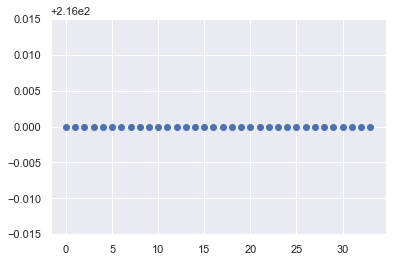

In [155]:
plt.scatter(group.loc[group['item_id']==255,'date_block_num'],group.loc[group['item_id']==255,'mean_price_mean'])

In [157]:
sales_train.loc[sales_train['item_id']==256]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
933036,04.09.2013,8,55,256,188.0,1.0,188.0
958099,18.10.2013,9,55,256,188.0,1.0,188.0
2306186,05.12.2014,23,55,256,188.0,1.0,188.0


# df_item_cnt

In [159]:
df_item_cnt = []
for i in range(34):
    df_item_cnt.append(np.array(list(product([i], sales_train.shop_id.unique(), sales_train.item_id.unique())), dtype='int16'))
    
df_item_cnt = pd.DataFrame(np.vstack(df_item_cnt), columns=cols)
df_item_cnt['date_block_num'] = df_item_cnt['date_block_num'].astype(np.int8)
df_item_cnt['shop_id'] = df_item_cnt['shop_id'].astype(np.int8)
df_item_cnt['item_id'] = df_item_cnt['item_id'].astype(np.int16)
df_item_cnt.sort_values(cols,inplace=True)
gc.collect()

21

In [160]:
group = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace = True)

In [161]:
df_item_cnt = pd.merge(df_item_cnt, group, how = 'left', on = ['date_block_num','shop_id','item_id'])
df_item_cnt.fillna(0, inplace = True)

In [162]:
gc.collect()

56

In [163]:
nearst = 30
df_item_cnt = neighbor_feature(df_item_cnt, nearst, 'item_cnt_month', 'no')

In [65]:
#nearst_lst = np.arange(-num_nearst, num_nearst+1)
#nearst_lst = list(set(nearst_lst).difference(set([0])))
#nearst_feature_lst = [f'item_cnt_month_nearst_{element}' for element in nearst_lst]

#for col in nearst_feature_lst:
#    df_item_cnt[col] = df_item_cnt[col].astype('float16')
#    gc.collect()

In [168]:
for num_nearst in [2, 10, 20, 30]:
    nearst_lst = np.arange(-num_nearst, num_nearst+1)
    nearst_lst = list(set(nearst_lst).difference(set([0])))
    nearst_feature_lst = [f'item_cnt_month_nearst_{element}' for element in nearst_lst]

    df_item_cnt[f'item_cnt_month_avg_nearst_{num_nearst}'] = df_item_cnt[nearst_feature_lst].mean(axis = 1)
    
df_item_cnt.drop(nearst_feature_lst, axis = 1, inplace = True)

In [169]:
df_item_cnt.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_avg_nearst_2,item_cnt_month_avg_nearst_10,item_cnt_month_avg_nearst_20,item_cnt_month_avg_nearst_30
0,0,2,0,0.0,0.0,0.0,0.0,0.033333335071802
1,0,2,1,0.0,0.0,0.0,0.0,0.032258063554764
2,0,2,2,0.0,0.0,0.0,0.0,0.031250000000000
3,0,2,3,0.0,0.0,0.0,0.0,0.060606062412262
4,0,2,4,0.0,0.0,0.0,0.0,0.058823529630899


In [170]:
df_item_cnt.columns[df_item_cnt.isna().any()].tolist()

[]

In [171]:
df_item_cnt.columns.to_series()[np.isinf(df_item_cnt).any()]

Series([], dtype: object)

In [172]:
gc.collect()

42

In [173]:
with open('df_item_cnt_01.pickle', 'wb') as handle:
    pickle.dump(df_item_cnt, handle, protocol = pickle.HIGHEST_PROTOCOL)

Category 2

In [174]:
df_item_cnt_2 = []
for i in range(34):
    df_item_cnt_2.append(np.array(list(product([i], sales_train.shop_id.unique(), test.loc[test['category']==2].item_id.unique())), dtype='int16'))
    
df_item_cnt_2 = pd.DataFrame(np.vstack(df_item_cnt_2), columns=cols)
df_item_cnt_2['date_block_num'] = df_item_cnt_2['date_block_num'].astype(np.int8)
df_item_cnt_2['shop_id'] = df_item_cnt_2['shop_id'].astype(np.int8)
df_item_cnt_2['item_id'] = df_item_cnt_2['item_id'].astype(np.int16)
df_item_cnt_2.sort_values(cols,inplace=True)
gc.collect()

21

In [175]:
ts = time.time()

nearst = 30
df_item_cnt_2 = neighbor_feature_2(df_item_cnt_2, df_item_cnt, nearst, 'item_cnt_month', 'no')

time.time() - ts

1037.0919387340546

In [80]:
#nearst_lst = np.arange(-nearst, nearst+1)
#nearst_lst = list(set(nearst_lst).difference(set([0])))
#nearst_feature_lst = [f'item_cnt_month_nearst_{element}' for element in nearst_lst]

#for col in nearst_feature_lst:
#    df_item_cnt_2[col] = df_item_cnt_2[col].astype('float16')
#    gc.collect()

In [176]:
for num_nearst in [1, 2, 10, 20, 30]:
    nearst_lst = np.arange(-num_nearst, num_nearst+1)
    nearst_lst = list(set(nearst_lst).difference(set([0])))
    nearst_feature_lst = [f'item_cnt_month_nearst_{element}' for element in nearst_lst]

    df_item_cnt_2[f'item_cnt_month_avg_nearst_{num_nearst}'] = df_item_cnt_2[nearst_feature_lst].mean(axis = 1)
    
df_item_cnt_2.drop(nearst_feature_lst, axis = 1, inplace = True)

In [177]:
df_item_cnt_2.columns[df_item_cnt_2.isna().any()].tolist()

['item_cnt_month_avg_nearst_1', 'item_cnt_month_avg_nearst_2']

In [178]:
df_item_cnt_2.columns.to_series()[np.isinf(df_item_cnt_2).any()]

Series([], dtype: object)

In [179]:
gc.collect()

63

In [90]:
len(df_item_cnt_2['item_cnt_month_avg_nearst_30'].unique())

1709

In [180]:
with open('df_item_cnt_2.pickle', 'wb') as handle:
    pickle.dump(df_item_cnt_2, handle, protocol = pickle.HIGHEST_PROTOCOL)

# df_revenue

In [ ]:
df_revenue = []
for i in range(34):
    df_revenue.append(np.array(list(product([i], sales_train.shop_id.unique(), sales_train.item_id.unique())), dtype='int16'))
    
df_revenue = pd.DataFrame(np.vstack(df_revenue), columns=cols)
df_revenue['date_block_num'] = df_revenue['date_block_num'].astype(np.int8)
df_revenue['shop_id'] = df_revenue['shop_id'].astype(np.int8)
df_revenue['item_id'] = df_revenue['item_id'].astype(np.int16)
df_revenue.sort_values(cols,inplace=True)
gc.collect()

In [ ]:
group = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'revenue': ['sum']})
group.columns = ['revenue_month']
group.reset_index(inplace = True)

In [ ]:
df_revenue = pd.merge(df_revenue, group, how = 'left', on = ['date_block_num','shop_id','item_id'])
df_revenue.fillna(0, inplace = True)

In [ ]:
nearst = 30
df_revenue = neighbor_feature(df_revenue, nearst, 'item_cnt_month', 'no')